### Group 1
Mandar Kathe

Samuel Vélez

## STEP 1: 

### Describe your dataset: where does the data come from, why was it created, when and how was it collected?

-------------------------------------------------------------------------------

## Project title: 
### *Project title*

*Source of the data*

## STEP 2: Load the dataset

------------------------------------------

In [4]:
import altair as alt
import pandas as pd
merged = pd.read_csv("merged_dataset.csv")



## STEP 5: Data Wrangling before Step 3 for initial exploration

------------------------------------------

In this dataset we find 14 columns, and we add a 15th one which proves necessary given our analysis: $Fe_{203} Flowrate$.

We enforce a rule dictating COMBT.C > REDT.C, as this means the measurement was taken correctly.

The dataset is already clean of NA values, and no further adjustment is necessary.


In [6]:
merged.columns = merged.columns.str.replace(' ', '')
merged.columns = merged.columns.str.replace('/', '_')
merged["FE203FLOWRATE"] = (merged["FE2O3KMOL_HR"]*2 + merged["FE3O4KMOL_HR"]*3+ merged["FEOKMOL_HR"] + merged["FETIO3KMOL_HR"] + merged["FEKMOL_HR"])/2
merged["H2_CO_RATIO"] = (merged["H2KMOL_HR"]/merged["COKMOL_HR"])
merged["H2_PLUS_CO"] = merged["H2KMOL_HR"] + merged["COKMOL_HR"]
temperature_condition = (merged["COMBTC"] - merged["REDTC"]) > 0
ratio_condition = ((merged["H2_CO_RATIO"] >= 2.18) & (merged["H2_CO_RATIO"] <=2.2))
merged = merged[temperature_condition]
merged.columns = merged.columns.str.replace('VARY2H2OINMIXEDTOTALMOLEFLOWKMOL_HR', 'CO2_in')
merged.columns = merged.columns.str.replace('VARY1CO2INMIXEDTOTALMOLEFLOWKMOL_HR', 'H2O_in')
merged["H2in_PLUS_COin"] = merged["H2O_in"] + merged["CO2_in"]
merged_subset = merged[ratio_condition].reset_index()[["H2KMOL_HR","COKMOL_HR","H2_CO_RATIO","H2_PLUS_CO", "CO2_in", "H2O_in", "temperature", "Fe203_flowrate", "ITCMO_support_fraction","factor_compressor","pressure","H2in_PLUS_COin"]]

## STEP 3: 

### Explore your dataset: Look at the columns using describe and summary, which ones are interesting, relevant?


----------------------------------------------------------

The dataset is almost perfectly balanced between different genders for each species, while the Chinstrap penguin is less represented overall.

The numerical columns are the most noticeable to start a comparison and start asking questions to try and relate them to the categorical variables, such as Species, Sex and Clutch Completion.

The categorical variables that prove too difficult or useless to analyze are the Stage variable, as it only contains adults in Stage 1 and the Region/Island variable, as it is too homogeneous in comparison with the other categorical variables and it becomes very difficult to hyphotetize on their differences.

In [7]:
alt.data_transformers.disable_max_rows()
merged_subset.describe()
merged_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3186 entries, 0 to 3185
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   H2KMOL_HR               3186 non-null   float64
 1   COKMOL_HR               3186 non-null   float64
 2   H2_CO_RATIO             3186 non-null   float64
 3   H2_PLUS_CO              3186 non-null   float64
 4   CO2_in                  3186 non-null   int64  
 5   H2O_in                  3186 non-null   int64  
 6   temperature             3186 non-null   object 
 7   Fe203_flowrate          3186 non-null   int64  
 8   ITCMO_support_fraction  3186 non-null   int64  
 9   factor_compressor       701 non-null    float64
 10  pressure                3186 non-null   int64  
 11  H2in_PLUS_COin          3186 non-null   int64  
dtypes: float64(5), int64(6), object(1)
memory usage: 298.8+ KB


In [8]:
H2_PLUS_CO_VS_RATIO = alt.Chart(merged_subset).mark_point().encode(
    alt.X("H2_PLUS_CO"),
    alt.Y('H2_CO_RATIO', scale=alt.Scale(domain=(2.18,2.2)))
    )

df1=merged_subset[["H2KMOL_HR","COKMOL_HR","H2_PLUS_CO"]].melt(id_vars='H2_PLUS_CO')
df1
H2_O2_VS_RATIO = alt.Chart(df1).mark_line().encode(
    alt.Y("value", title = "Content per hour"),
    alt.X('H2_PLUS_CO', title = "Total H2 + CO"),
    color = "variable"
    )

H2_PLUS_CO_VS_RATIO | H2_O2_VS_RATIO

alt.HConcatChart(...)

In [14]:
#CO and H2 ins
h20_in_vssum = alt.Chart(merged_subset).mark_point().encode(
    alt.Y("H2_PLUS_CO"),
    alt.X('H2O_in')
    )
co2_in_vssum = alt.Chart(merged_subset).mark_point().encode(
    alt.Y("H2_PLUS_CO"),
    alt.X('CO2_in')
    )
test1 = alt.Chart(merged_subset).mark_point().encode(
    alt.Y("H2_PLUS_CO"),
    alt.X('H2in_PLUS_COin')
    )
co2_in_vssum | h20_in_vssum | test1

alt.HConcatChart(...)

Text(0.5, 0.92, 'surface')

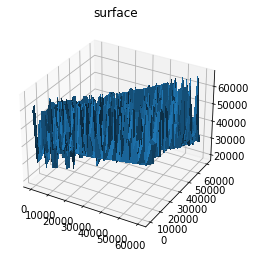

In [15]:
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')

X = merged_subset["CO2_in"]
Y = merged_subset["H2O_in"]
Z = merged_subset["H2_PLUS_CO"]

ax = plt.axes(projection='3d')
ax.plot_trisurf(X, Y, Z, linewidth=0, antialiased=False)
ax.set_title('surface')

In [16]:
df1=merged_subset[["temperature","H2_PLUS_CO"]].melt(id_vars=['H2_PLUS_CO'])
df1
temperature_h2_co = alt.Chart(df1, title = "Temperature per Total H2 + CO").transform_density(
    'H2_PLUS_CO',
    as_=['H2_PLUS_CO', 'density'],
    # extent=[5, 50],
    groupby=['value']
).mark_area(orient='horizontal').encode(
    y='H2_PLUS_CO:Q',
    color='value:N',
    x=alt.X(
        'density:Q',
        stack='center',
        impute=None,
        title=None,
        axis=alt.Axis(labels=False, values=[0],grid=False, ticks=True)
    ),
    # facet=alt.Facet(column = 'variable:O'),
    column=alt.Column(
        'value:N',
        header=alt.Header(
            titleOrient='bottom',
            labelOrient='bottom',
            labelPadding=0
        )
    )
).properties(
    width=100
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
)

temperature_h2_co

alt.Chart(...)

In [17]:
df1=merged_subset[["pressure","H2_PLUS_CO"]].melt(id_vars=['H2_PLUS_CO'])
df1
pressure_h2_co = alt.Chart(df1, title = "Pressure per Total H2 + CO").transform_density(
    'H2_PLUS_CO',
    as_=['H2_PLUS_CO', 'density'],
    # extent=[5, 50],
    groupby=['value']
).mark_area(orient='horizontal').encode(
    y='H2_PLUS_CO:Q',
    color='value:N',
    x=alt.X(
        'density:Q',
        stack='center',
        impute=None,
        title=None,
        axis=alt.Axis(labels=False, values=[0],grid=False, ticks=True)
    ),
    # facet=alt.Facet(column = 'variable:O'),
    column=alt.Column(
        'value:N',
        header=alt.Header(
            titleOrient='bottom',
            labelOrient='bottom',
            labelPadding=0
        )
    )
).properties(
    width=100
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
)

pressure_h2_co

alt.Chart(...)

In [275]:
df1=merged_subset[["Fe203_flowrate","H2_PLUS_CO"]].melt(id_vars=['H2_PLUS_CO'])
df1
pressure_h2_co = alt.Chart(df1, title = "Fe 203 Flowrate per Total H2 + CO").transform_density(
    'H2_PLUS_CO',
    as_=['H2_PLUS_CO', 'density'],
    # extent=[5, 50],
    groupby=['value']
).mark_area(orient='horizontal').encode(
    y='H2_PLUS_CO:Q',
    color='value:N',
    x=alt.X(
        'density:Q',
        stack='center',
        impute=None,
        title=None,
        axis=alt.Axis(labels=False, values=[0],grid=False, ticks=True)
    ),
    # facet=alt.Facet(column = 'variable:O'),
    column=alt.Column(
        'value:N',
        header=alt.Header(
            titleOrient='bottom',
            labelOrient='bottom',
            labelPadding=0
        )
    )
).properties(
    width=100
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
)

pressure_h2_co

alt.Chart(...)

In [277]:
df1=merged_subset[["ITCMO_support_fraction","H2_PLUS_CO"]].melt(id_vars=['H2_PLUS_CO'])
df1
pressure_h2_co = alt.Chart(df1, title = "ITCMO Support Fraction vs H2 + CO").transform_density(
    'H2_PLUS_CO',
    as_=['H2_PLUS_CO', 'density'],
    # extent=[5, 50],
    groupby=['value']
).mark_area(orient='horizontal').encode(
    y='H2_PLUS_CO:Q',
    color='value:N',
    x=alt.X(
        'density:Q',
        stack='center',
        impute=None,
        title=None,
        axis=alt.Axis(labels=False, values=[0],grid=False, ticks=True)
    ),
    # facet=alt.Facet(column = 'variable:O'),
    column=alt.Column(
        'value:N',
        header=alt.Header(
            titleOrient='bottom',
            labelOrient='bottom',
            labelPadding=0
        )
    )
).properties(
    width=100
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
)

pressure_h2_co

alt.Chart(...)

In [278]:
df1=merged_subset[["factor_compressor","H2_PLUS_CO"]].melt(id_vars=['H2_PLUS_CO'])
df1
pressure_h2_co = alt.Chart(df1, title = "Factor Compressor vs H2 + CO").transform_density(
    'H2_PLUS_CO',
    as_=['H2_PLUS_CO', 'density'],
    # extent=[5, 50],
    groupby=['value']
).mark_area(orient='horizontal').encode(
    y='H2_PLUS_CO:Q',
    color='value:N',
    x=alt.X(
        'density:Q',
        stack='center',
        impute=None,
        title=None,
        axis=alt.Axis(labels=False, values=[0],grid=False, ticks=True)
    ),
    # facet=alt.Facet(column = 'variable:O'),
    column=alt.Column(
        'value:N',
        header=alt.Header(
            titleOrient='bottom',
            labelOrient='bottom',
            labelPadding=0
        )
    )
).properties(
    width=100
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
)

pressure_h2_co

alt.Chart(...)

## STEP 6:  Research questions. Aim for descriptive or exploratory questions

------------------------------------------

### Research Question #1


**Research Question 1 Statement:**

### Research Question #2

**Research Question 2 Statement:**

## STEP 7
**Data analysis and visualization: Create visualizations, and explain why you chose them, that will help you answer your research question**

------------------------------------


Warning message:
"Removed 9 rows containing non-finite values (stat_ydensity)."


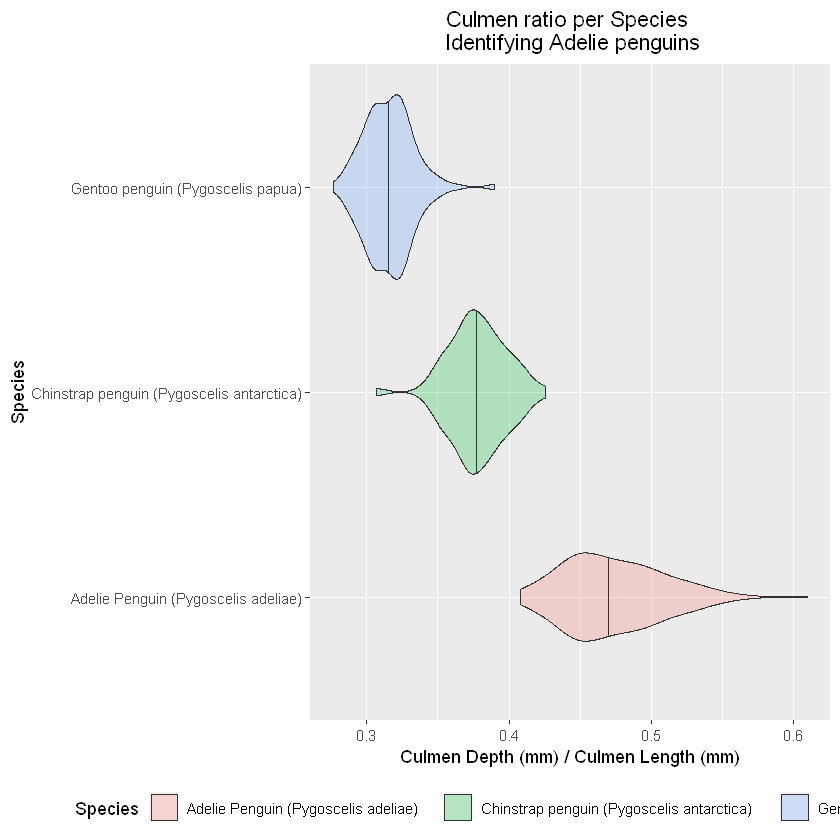

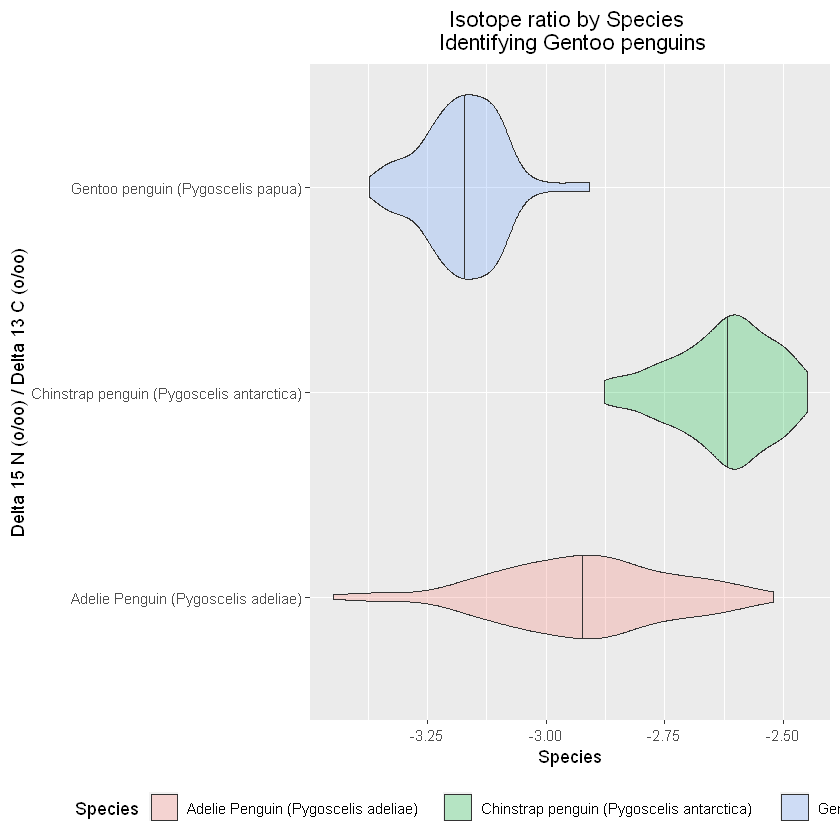

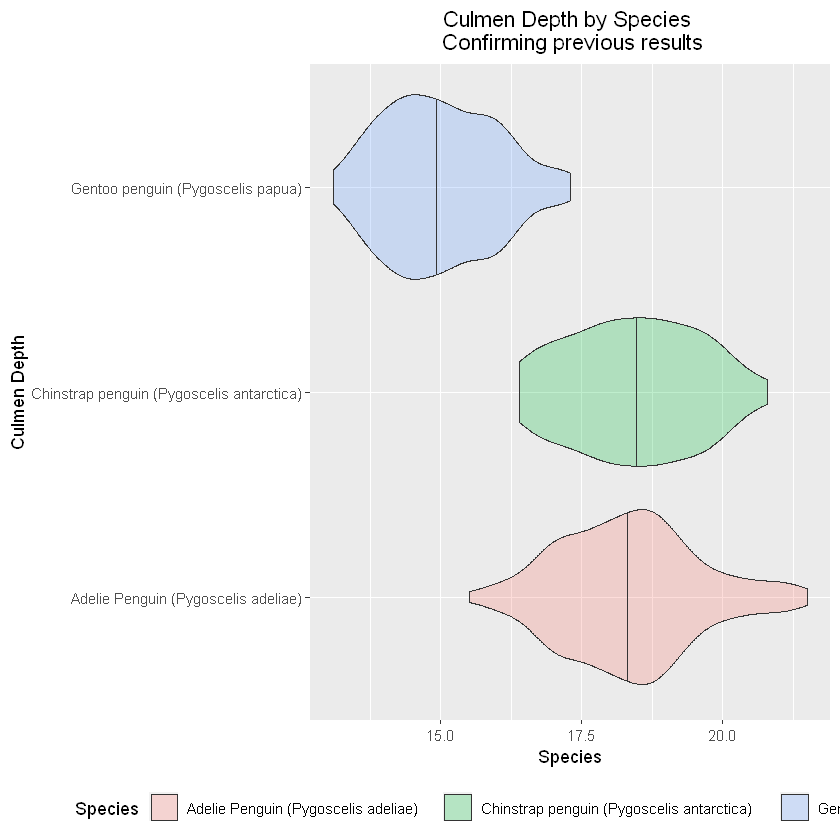

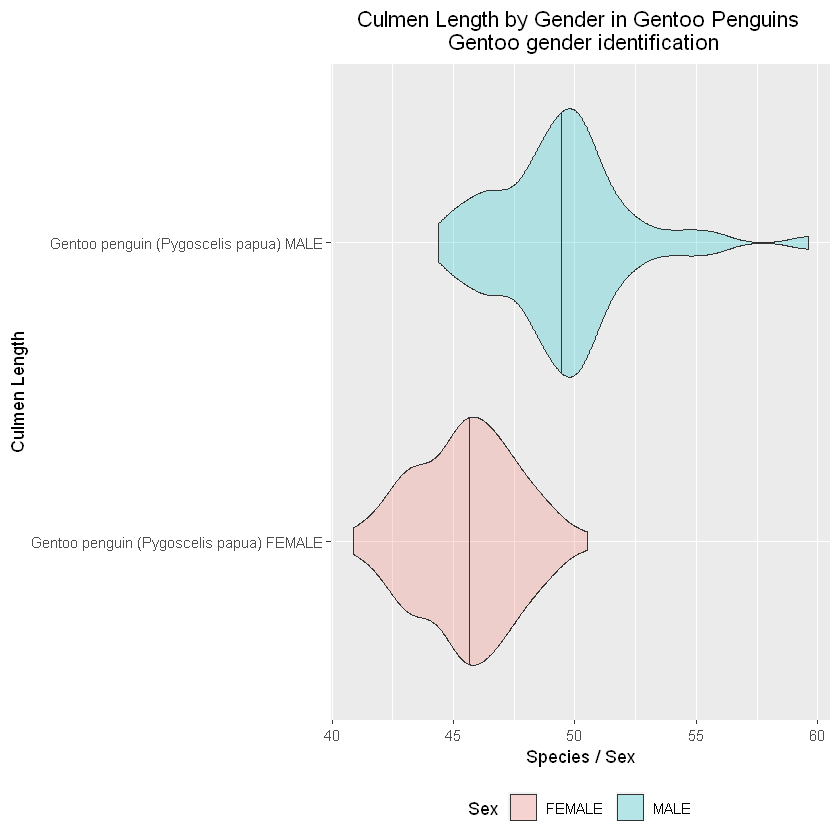

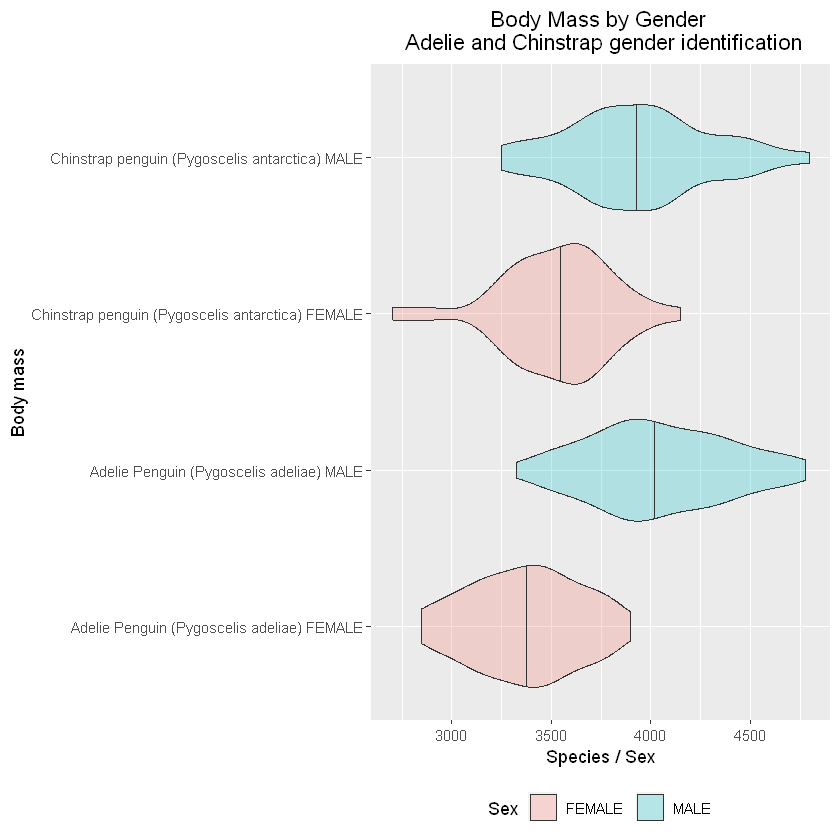

## STEP 8
**Conclusions and future research questions**

------------------------------------